### imports


In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import svm
import emission.analysis.modelling.trip_model.run_model as eamtr
from uuid import UUID

import emission.storage.timeseries.abstract_timeseries as esta
import emission.storage.decorations.trip_queries as esdtq
import emission.core.get_database as edb

import data_wrangling
from clustering import add_loc_clusters

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!
analysis.trip_model.conf.json not configured, falling back to sample, default configuration
storage not configured, falling back to sample, def

### load data


In [2]:
# Please contact the corresponding author for the emails/uuids of the data used in the paper.
suburban_email = "stage_d3GBLDSVzn4"
college_campus_email = "stage_OlTMUasqLbxL7KfI"
suburban_uuid = list(edb.get_uuid_db().find({"user_email":
                                             suburban_email}))[0]['uuid']
college_campus_uuid = list(edb.get_uuid_db().find(
    {"user_email": college_campus_email}))[0]['uuid']

uuids = [suburban_uuid, college_campus_uuid]
confirmed_trip_df_map = {}
labeled_trip_df_map = {}
ct_entry={}
expanded_trip_df_map = {}
for u in uuids:
    ts = esta.TimeSeries.get_time_series(u)
    ct_df = ts.get_data_df("analysis/confirmed_trip")
    ct_entry[u]=eamtr._get_training_data(u,None)   
    confirmed_trip_df_map[u] = ct_df
    labeled_trip_df_map[u] = esdtq.filter_labeled_trips(ct_df)
    expanded_trip_df_map[u] = esdtq.expand_userinputs(labeled_trip_df_map[u])

found 972 training rows
found 449 training rows


### SVM exploration for single clusters


#### Set up data so that we can look at some specific clusters first.


In [3]:
def setup(user_df,
          alg,
          loc_type,
          radii=[50, 100, 150, 200],
          cluster_unlabeled=False):
    """ copied and modified from find_plot_clusters() in mapping """
    # clean up the dataframe by dropping entries with NaN locations and
    # resetting index because oursim needs the position of each trip to match
    # its nominal index
    all_trips_df = user_df.dropna(subset=['start_loc', 'end_loc']).reset_index(
        drop=True)

    # expand the 'start/end_loc' column into 'start/end_lat/lon' columns
    all_trips_df = data_wrangling.expand_coords(all_trips_df)

    labeled_trips_df = all_trips_df.loc[all_trips_df.user_input != {}]
    df_for_cluster = all_trips_df if cluster_unlabeled else labeled_trips_df

    df_for_cluster = add_loc_clusters(df_for_cluster,
                                      ct_entry,
                                      clustering_way='destination',
                                      radii=radii,
                                      alg=alg,
                                      loc_type=loc_type,
                                      min_samples=2)

    return df_for_cluster


suburb_df = expanded_trip_df_map[suburban_uuid]
college_df = expanded_trip_df_map[college_campus_uuid]

suburb_df = setup(suburb_df,
                  alg='DBSCAN',
                  loc_type='end',
                  radii=[100, 150],
                  cluster_unlabeled=False)
college_df = setup(college_df,
                   alg='DBSCAN',
                   loc_type='end',
                   radii=[150],
                   cluster_unlabeled=False)


In [4]:
alg = 'DBSCAN'
loc_type = 'end'

c1 = college_df.loc[(college_df[f'{loc_type}_{alg}_clusters_150_m'] == 1
                     )].loc[:,
                            ['end_lat', 'end_lon', 'purpose_confirm']].dropna()

c2 = suburb_df.loc[(suburb_df[f'{loc_type}_{alg}_clusters_100_m'] == 1
                    )].loc[:,
                           ['end_lat', 'end_lon', 'purpose_confirm']].dropna()
c3 = suburb_df.loc[(suburb_df[f'{loc_type}_{alg}_clusters_150_m'] == 1
                    )].loc[:,
                           ['end_lat', 'end_lon', 'purpose_confirm']].dropna()

In [5]:
plt.style.use("default")


def vis_pred(cluster):
    # setup up model
    X = cluster.loc[:, ['end_lon', 'end_lat']]
    Y = cluster.loc[:, 'purpose_confirm']

    model = make_pipeline(
        StandardScaler(),
        svm.SVC(kernel='rbf', gamma=0.05, C=1, decision_function_shape='ovr'))

    # train models
    # fit() wants Y as an array, not a column vector
    model.fit(X, Y.to_list())

    # vars for visualizing decision functions
    min_lat = X[['end_lat']].min()
    max_lat = X[['end_lat']].max()
    min_lon = X[['end_lon']].min()
    max_lon = X[['end_lon']].max()
    width = max_lon - min_lon
    height = max_lat - min_lat
    xx, yy = np.meshgrid(
        np.linspace(min_lon - 0.05 * width, max_lon + 0.05 * width, 500),
        np.linspace(min_lat - 0.05 * height, max_lat + 0.05 * height, 500))

    num_classes = len(model.classes_)
    label_map = {model.classes_[i]: i for i in range(num_classes)}

    pred = model.predict(np.c_[xx.ravel(), yy.ravel()])
    pred = [label_map[p] for p in pred]
    pred = np.array(pred).reshape((xx.shape[0], xx.shape[1]))

    fig, ax = plt.subplots(figsize=(5.45, 4))

    ## Prepare bins for the normalizer
    ## normalize the colors
    norm_bins = np.sort([*label_map.values()]) + 0.5
    norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)
    norm = matplotlib.colors.BoundaryNorm(norm_bins, num_classes, clip=True)

    if num_classes <= 10:
        cm = plt.cm.tab10
    else:
        cm = plt.cm.tab20

    im = ax.imshow(
        pred,
        interpolation="none",
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        aspect="auto",
        origin="lower",
        cmap=cm,
        norm=norm,
    )

    ax.scatter(
        X['end_lon'],
        X['end_lat'],
        c=Y.map(label_map).to_list(),
        cmap=cm,
        edgecolors="k",
        norm=norm,
    )
    ax.set_xticks([])
    ax.set_yticks([])
    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.5, right=1)

    plt.axis('scaled')
    # plt.tight_layout()
    plt.show()

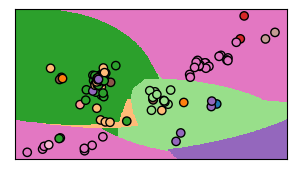

In [6]:
vis_pred(c3)

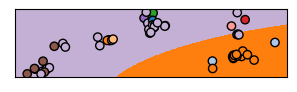

In [7]:
vis_pred(c1)

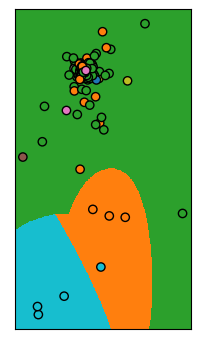

In [8]:
vis_pred(c2)